## Isolation Forest

강사노트 [링크](https://www.kaggle.com/code/linakeepgoing/chatper6-fraud-detection-with-isolation-forest)

데이터 = 숲     
이상치 = 고립된 나무 

동장 방식  
1. 나무 생성 : 데이터를 분리하기 위해 IsolationTree라는 특수한 나무를 만듦. 이 과정에서는 랜덤으로 특성을 선택하고 그 특성의 최솟값과 최댓값 사이의 랜덤한 값을 분할값으로 사용하여 데이터를 분할. 서비셋이 더 이상 분할할 수 없거나 나무가 지정된 최대 깊이에 도달할 때까지 계속 분할.
2. 평균 경로 길이 계산 : 분리된 각 데이터 포인트까지의 경로 길이를 계산. 이상치는 주변에 비슷한 데이터가 없기 때문에 일반적으로 더 짧은 경로 길이로 분리됨. 
3. 이상치 점수 계산 : 각 나무에서 계산된 평균 경로 길이를 이용하여 이상치 점수를 계산. 점수는 0과 1사이로 이 값이 클수록 해당 데이터 포인트가 이상치일 확률이 높음.   
     이상치 계산 공식   $  S(x,n) = 2^{(-E(h(x))/c(n))}     $   
     E(h(x)) : 샘플 x의 평균 경로 길이 h(x)의 평균   
     c(n) : n개의 샘플이 가진 이진 탐색 트리의 평균 경로 길이
4. 이상치 점수가 임곗값 보다 크면 이상치로 판단

-------------
Isolation Forest 알고리즘은 높은 차원의 데이터에서도 효과적으로 이상치 탐지할 수 있음.  

가장 근본적인 가정 1) 이상치는 전체 데이터에서 차지하는 비율이 매우 적음. 2) 이상치와 정상 데이터 사이에 큰 차이가 있음.


알고리즘의 핵심 아이디어는 이상치가 이진 트리에서 리프노트로 더 빠르게 분리된다는 점. 즉 이상치는 트리의 루트노드와의 거리가 짧아, 이를 통해 이상치를 효과적으로 식별 가능

In [2]:
# 필요한 라이브러리 불러오기
import numpy   as np
import pandas  as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest

import warnings
warnings.filterwarnings('ignore')

In [4]:
data_path = '../data/creditcard.csv'
data = pd.read_csv(data_path)

data.Class.value_counts()

Class
0    284315
1       492
Name: count, dtype: int64

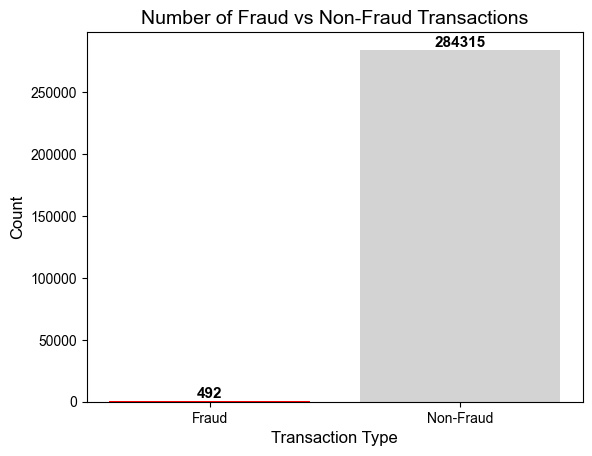

In [5]:
num_nonfraud = np.sum(data['Class'] == 0)
num_fraud = np.sum(data['Class'] == 1)

plt.bar(['Fraud', 'Non-Fraud'], [num_fraud, num_nonfraud], color=['red', 'lightgrey'])
plt.title('Number of Fraud vs Non-Fraud Transactions', fontsize=14)
plt.xlabel('Transaction Type', fontsize=12)
plt.ylabel('Count', fontsize=12)

# 막대 그래프 위에 수치 표시
for i, value in enumerate([num_fraud, num_nonfraud]):
    plt.text(i, value, str(value), ha='center', va='bottom', fontsize=11, fontweight='bold')

# 그래프 배경 스타일 설정
plt.style.use('seaborn-whitegrid')

plt.show()

In [6]:
data['Hour'] = data["Time"].apply(lambda x : divmod(x, 3600)[0])
X = data.drop(['Time','Class'],axis=1)
Y = data.Class

In [7]:
# 모델 훈련
iforest = IsolationForest()
# fit_predict 함수로 훈련 및 예측을 동시에 수행하여 모델에서의 이상치 여부를 판단합니다. -1은 이상치, 1은 정상을 의미합니다.
data['label'] = iforest.fit_predict(X)
# decision_function을 사용하여 예측을 통해 이상치 점수를 얻을 수 있습니다.
data['scores'] = iforest.decision_function(X)
# TopN 정확도 평가
n = 1000
df = data.sort_values(by='scores', ascending=True)
df = df.head(n)
rate = df[df['Class'] == 1].shape[0] / n
print('Top{}의 정확도는: {}'.format(n, rate))

Top1000의 정확도는: 0.144


실망스러운 정확도

In [8]:
iforest.get_params()

{'bootstrap': False,
 'contamination': 'auto',
 'max_features': 1.0,
 'max_samples': 'auto',
 'n_estimators': 100,
 'n_jobs': None,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

n_estimators: 사용할 결정 트리의 개수. 기본값은 100.   
contamination: 이상치로 간주할 비율을 나타냅니다. 기본값은 'auto'로 설정되어 데이터셋에서 자동으로 계산.  
max_samples: 각 결정 트리에 사용될 최대 샘플 수. 기본값은 'auto'로 설정되어 데이터셋 크기에 기반하여 자동으로 계산.   
random_state: 난수 생성 시드. 일관된 결과를 얻으려면 고정된 값을 사용할 수 있습니다. 기본값은 None으로 설정되어 난수가 매번 다르게 생성.  

Top1000의 정확도: 0.114
Top1000의 정확도: 0.189
Top1000의 정확도: 0.189
Top1000의 정확도: 0.192
Top1000의 정확도: 0.202
Top1000의 정확도: 0.196
Top1000의 정확도: 0.191
Top1000의 정확도: 0.184
Top1000의 정확도: 0.183
Top1000의 정확도: 0.186


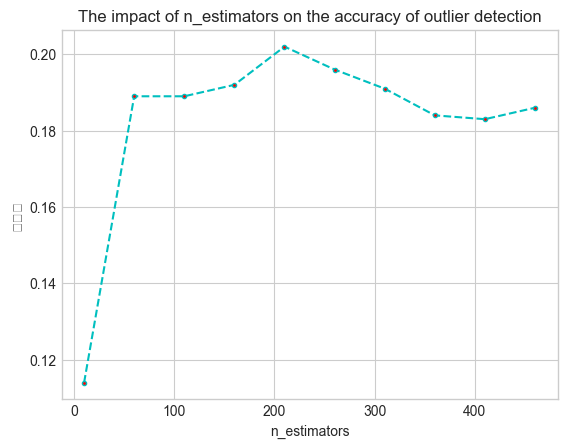

In [10]:
# n_estimator 찾기 
import warnings
import matplotlib.pyplot as plt

warnings.filterwarnings('ignore')  # 경고 메시지 무시

n_est = list(range(10, 500, 50))
rates = []

for i in n_est:
    # 모델 훈련
    iforest = IsolationForest(n_estimators=i, 
                              max_samples=256,  
                              contamination=0.02, 
                              max_features=5,  
                              random_state=1
                              )
    # fit_predict 함수로 모델 훈련 및 예측
    data['label'] = iforest.fit_predict(X) 
    # decision_function으로 이상치 점수 예측
    data['scores'] = iforest.decision_function(X)  
    # TopN 정확도 평가
    n = 1000
    df = data.sort_values(by='scores', ascending=True)
    df = df.head(n)
    rate = df[df['Class']==1].shape[0] / n
    print('Top{}의 정확도: {}'.format(n, rate))
    rates.append(rate)

# 그래프 그리기
plt.style.use('seaborn-whitegrid')
plt.plot(n_est, rates, linestyle='--', marker='.', color='c', markerfacecolor='red')
plt.xlabel('n_estimators')
plt.ylabel('정확도')
plt.title('The impact of n_estimators on the accuracy of outlier detection')

# 그래프 표시
plt.show()

n_estimator 가 200기준으로 정확도 감소 시작. 나무 개수가 많다고 해서 항상 더 좋은 성능 보장하는 것 아님

Top1000의 정확도는: 0.198
Top1000의 정확도는: 0.195
Top1000의 정확도는: 0.188
Top1000의 정확도는: 0.191
Top1000의 정확도는: 0.192
Top1000의 정확도는: 0.185
Top1000의 정확도는: 0.184
Top1000의 정확도는: 0.161
Top1000의 정확도는: 0.158
Top1000의 정확도는: 0.166
Top1000의 정확도는: 0.209
Top1000의 정확도는: 0.183
Top1000의 정확도는: 0.174
Top1000의 정확도는: 0.169
Top1000의 정확도는: 0.164
Top1000의 정확도는: 0.154
Top1000의 정확도는: 0.167
Top1000의 정확도는: 0.17
Top1000의 정확도는: 0.183
Top1000의 정확도는: 0.149
Top1000의 정확도는: 0.186
Top1000의 정확도는: 0.18
Top1000의 정확도는: 0.183
Top1000의 정확도는: 0.195
Top1000의 정확도는: 0.187
Top1000의 정확도는: 0.157
Top1000의 정확도는: 0.191
Top1000의 정확도는: 0.189
Top1000의 정확도는: 0.146
Top1000의 정확도는: 0.23
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]
[0.198, 0.195, 0.188, 0.191, 0.192, 0.185, 0.184, 0.161, 0.158, 0.166, 0.209, 0.183, 0.174, 0.169, 0.164, 0.154, 0.167, 0.17, 0.183, 0.149, 0.186, 0.18, 0.183, 0.195, 0.187, 0.157, 0.191, 0.189, 0.146, 0.23]


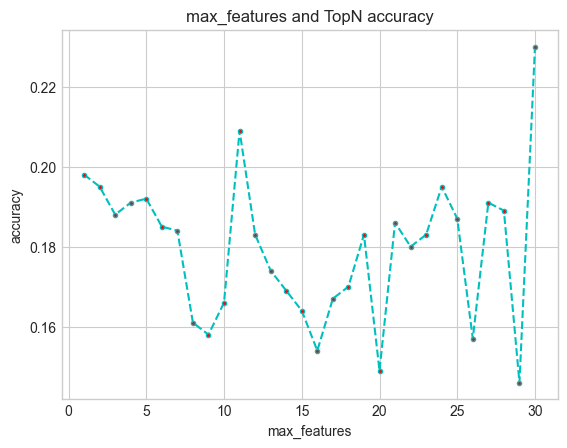

In [11]:
# max_feature 찾기 

features = list(range(1, X.shape[1]+1))
rates = []
for i in features:
    # 모델 훈련
    iforest = IsolationForest(n_estimators=100,
                              max_samples=256,
                              contamination=0.02,
                              max_features=i,
                              random_state=1
                              )
    # fit_predict 함수로 훈련 및 예측을 동시에 수행하여 모델에서의 이상치 여부를 판단합니다. -1은 이상치, 1은 정상을 의미합니다.
    data['label'] = iforest.fit_predict(X)
    # decision_function을 사용하여 예측을 통해 이상치 점수를 얻을 수 있습니다.
    data['scores'] = iforest.decision_function(X)
    # Top-N 정확도 평가
    n = 1000
    df = data.sort_values(by='scores', ascending=True)
    df = df.head(n)
    rate = df[df['Class'] == 1].shape[0] / n
    print('Top{}의 정확도는: {}'.format(n, rate))
    rates.append(rate)

print(features)
print(rates)

import matplotlib.pyplot as plt
plt.plot(features, rates, linestyle='--', marker='.', color='c', markerfacecolor='red')
plt.title('max_features and TopN accuracy')
plt.xlabel('max_features')
plt.ylabel('accuracy')
plt.show()

특성 30개 전부 다 썼을 때 정확도 젤 높은건 의미 x -> 모델의 상관성이 높아서 통합 정확도 하락     
샘플 수 1200으로 늘려서 다시 확인    

Top1000의 정확도는: 0.195
Top1000의 정확도는: 0.197
Top1000의 정확도는: 0.204
Top1000의 정확도는: 0.183
Top1000의 정확도는: 0.208
Top1000의 정확도는: 0.191
Top1000의 정확도는: 0.221
Top1000의 정확도는: 0.195
Top1000의 정확도는: 0.167
Top1000의 정확도는: 0.204
Top1000의 정확도는: 0.197
Top1000의 정확도는: 0.171
Top1000의 정확도는: 0.182
Top1000의 정확도는: 0.205
Top1000의 정확도는: 0.193
Top1000의 정확도는: 0.173
Top1000의 정확도는: 0.206
Top1000의 정확도는: 0.194
Top1000의 정확도는: 0.224
Top1000의 정확도는: 0.188
Top1000의 정확도는: 0.215
Top1000의 정확도는: 0.189
Top1000의 정확도는: 0.218
Top1000의 정확도는: 0.178
Top1000의 정확도는: 0.209
Top1000의 정확도는: 0.181
Top1000의 정확도는: 0.212
Top1000의 정확도는: 0.18
Top1000의 정확도는: 0.178
Top1000의 정확도는: 0.22
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]
[0.195, 0.197, 0.204, 0.183, 0.208, 0.191, 0.221, 0.195, 0.167, 0.204, 0.197, 0.171, 0.182, 0.205, 0.193, 0.173, 0.206, 0.194, 0.224, 0.188, 0.215, 0.189, 0.218, 0.178, 0.209, 0.181, 0.212, 0.18, 0.178, 0.22]


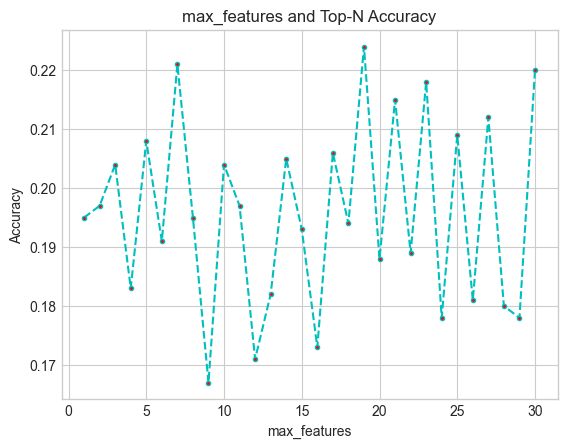

In [12]:
features = list(range(1, X.shape[1]+1))
rates = []

for i in features:
    # 모델 훈련
    iforest = IsolationForest(n_estimators=100,
                              max_samples=1200,
                              contamination=0.02,
                              max_features=i,
                              random_state=1
                              )
    # fit_predict 함수로 훈련 및 예측을 동시에 수행하여 모델에서의 이상치 여부를 판단합니다. -1은 이상치, 1은 정상을 의미합니다.
    data['label'] = iforest.fit_predict(X)
    # decision_function을 사용하여 예측을 통해 이상치 점수를 얻을 수 있습니다.
    data['scores'] = iforest.decision_function(X)
    # Top-N 정확도 평가
    n = 1000
    df = data.sort_values(by='scores', ascending=True)
    df = df.head(n)
    rate = df[df['Class'] == 1].shape[0] / n
    print('Top{}의 정확도는: {}'.format(n, rate))
    rates.append(rate)

print(features)
# [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]

print(rates)
# [0.198, 0.195, 0.188, 0.191, 0.192, 0.185, 0.184, 0.161, 0.158, 0.166, 0.209, 0.183, 0.174, 0.169, 0.164, 0.154, 0.167, 0.17, 0.183, 0.149, 0.186, 0.18, 0.183, 0.195, 0.187, 0.157, 0.191, 0.189, 0.146, 0.23]

import matplotlib.pyplot as plt
plt.plot(features, rates, linestyle='--', marker='.', color='c', markerfacecolor='red')
plt.title('max_features and Top-N Accuracy')
plt.xlabel('max_features')
plt.ylabel('Accuracy')
plt.show()

샘플 수를 늘릴수록 정확도와 max_features의 영향이 극단적이지 않음. 대략 7 정도의 값에서 좋은 성능이 보일 것으로 예상. (샘플 크기가 클수록 정확도 올릴 수 있음)

Top1000의 정확도는:0.142
Top1000의 정확도는:0.179
Top1000의 정확도는:0.179
Top1000의 정확도는:0.198
Top1000의 정확도는:0.193
Top1000의 정확도는:0.221
Top1000의 정확도는:0.214
Top1000의 정확도는:0.205
Top1000의 정확도는:0.229
Top1000의 정확도는:0.238


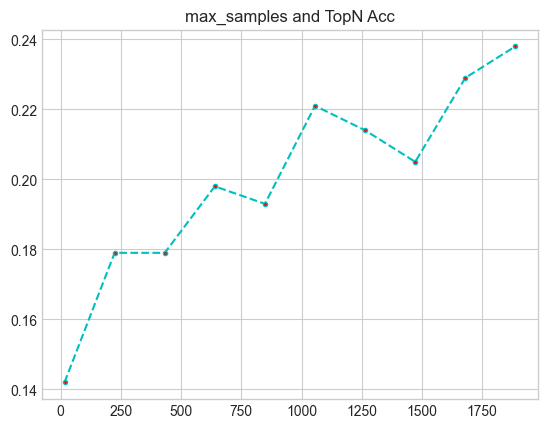

In [13]:
samples = list(range(16,2066,208))
rates = []
for i in samples:
    # 모델 훈련
    iforest = IsolationForest(n_estimators=100, 
                              max_samples= i,  
                              contamination=0.02, 
                              max_features=5,  
                              random_state=1
                              )
    # fit_predict 함수를 이용해 훈련과 예측을 함께 수행하며, -1은 이상치, 1은 정상치를 나타냄
    data['label'] = iforest.fit_predict(X) 
    # decision_function을 이용해 이상치 점수를 예측
    data['scores'] = iforest.decision_function(X)  
    # TopN 정확도 평가
    n = 1000
    df =  data.sort_values(by='scores',ascending=True)
    df = df.head(n)
    rate = df[df['Class']==1].shape[0]/n
    print('Top{}의 정확도는:{}'.format(n,rate))
    rates.append(rate)
    
import matplotlib.pyplot as plt
plt.plot(samples,rates, linestyle='--', marker='.',color='c',markerfacecolor='red')
plt.title('max_samples and TopN Acc')
plt.show()

Top1000의 정확도:0.105
Top1000의 정확도:0.227
Top1000의 정확도:0.238
Top1000의 정확도:0.231
Top1000의 정확도:0.247
Top1000의 정확도:0.242
Top1000의 정확도:0.228
Top1000의 정확도:0.245
Top1000의 정확도:0.248
Top1000의 정확도:0.248
Top1000의 정확도:0.242
Top1000의 정확도:0.225
Top1000의 정확도:0.23
Top1000의 정확도:0.235
Top1000의 정확도:0.243
Top1000의 정확도:0.254
Top1000의 정확도:0.252
Top1000의 정확도:0.244
Top1000의 정확도:0.235
Top1000의 정확도:0.246
Top1000의 정확도:0.255
Top1000의 정확도:0.249
Top1000의 정확도:0.251
Top1000의 정확도:0.242
Top1000의 정확도:0.235
Top1000의 정확도:0.246
Top1000의 정확도:0.251
Top1000의 정확도:0.254
Top1000의 정확도:0.244
Top1000의 정확도:0.24
Top1000의 정확도:0.225
Top1000의 정확도:0.233
Top1000의 정확도:0.247
Top1000의 정확도:0.253
Top1000의 정확도:0.236
Top1000의 정확도:0.252
Top1000의 정확도:0.23
Top1000의 정확도:0.246
Top1000의 정확도:0.261
Top1000의 정확도:0.252
Top1000의 정확도:0.251
Top1000의 정확도:0.254
Top1000의 정확도:0.252
Top1000의 정확도:0.231
Top1000의 정확도:0.246
Top1000의 정확도:0.235
Top1000의 정확도:0.238
Top1000의 정확도:0.246
Top1000의 정확도:0.261
Top1000의 정확도:0.247
Top1000의 정확도:0.228
Top1000의 정확도:0.243
Top1000의 정확도:0.

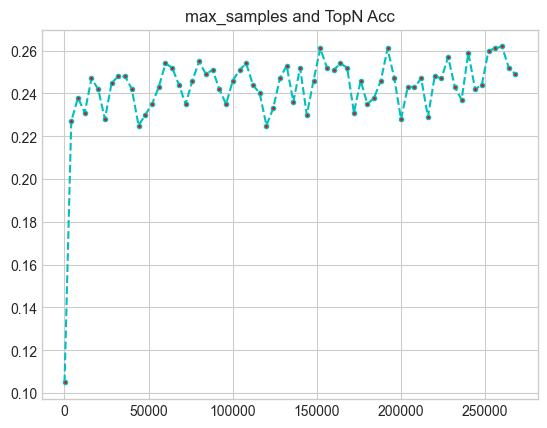

In [14]:
# max_samples 더 늘려~
samples = list(range(50,270000,4000))
# 정확도를 저장할 빈 리스트를 생성합니다.
rates = []

# 각 샘플 크기에 대해 반복합니다.
for i in samples:
    # 모델을 학습시킵니다.
    iforest = IsolationForest(n_estimators=100, 
                              max_samples = i,  
                              contamination=0.02, 
                              max_features=5,  
                              random_state=1
                              )
    # fit_predict 함수를 사용하여 데이터를 학습하고 예측합니다. 이상치는 -1, 정상은 1로 표시됩니다.
    data['label'] = iforest.fit_predict(X) 
    # decision_function을 사용하여 이상치 점수를 계산합니다.
    data['scores'] = iforest.decision_function(X)  
    # TopN 정확도를 평가합니다.
    n = 1000
    # 점수가 낮은 순서대로 데이터를 정렬합니다.
    df =  data.sort_values(by='scores',ascending=True)
    # Top N 데이터를 선택합니다.
    df = df.head(n)
    # 선택된 데이터 중 이상치의 비율을 계산합니다.
    rate = df[df['Class']==1].shape[0]/n
    print('Top{}의 정확도:{}'.format(n,rate))
    # 정확도를 rates 리스트에 추가합니다.
    rates.append(rate)
    
# 결과를 그래프로 시각화합니다.
import matplotlib.pyplot as plt
plt.plot(samples,rates, linestyle='--', marker='.',color='c',markerfacecolor='red')
plt.title('max_samples and TopN Acc')
plt.show()

max_samples 설정의 중요성 ~

이제 주요 파라미터 값을 변경 후 다시 모델 학습하여 성능 검토 

In [ ]:
# 모델 훈련
iforest = IsolationForest(n_estimators=250, 
                          max_samples = 125000,  
                          contamination=0.05, 
                          max_features=5,  
                          random_state=1
                          )
# fit_predict 함수를 이용해 훈련과 예측을 함께 수행하며, -1은 이상치, 1은 정상치를 나타냄
data['label'] = iforest.fit_predict(X) 
# decision_function을 이용해 이상치 점수를 예측
data['scores'] = iforest.decision_function(X)  
# TopN 정확도 평가
n = 1000
df =  data.sort_values(by='scores',ascending=True)
df = df.head(n)
rate = df[df['Class']==1].shape[0]/n
print('Top{}의 정확도는:{}'.format(n,rate))

# Top1000 데이터 저장
# df.to_csv('../data/credit_result_df.csv',header=True,index=False)

Top1000의 정확도는:0.251


## 결론

Isolation Forest 라는 이상치 탐지 모델을 이용하여 데이터의 이상치를 감지하고, 감지 결과에 대한 Top N 정확도를 평가함.  

N = 1000이며, 가장 높은 이상치 점수를 가진 상위 1000개의 데이터를 추출하여 이 중 실제 이상치 비율을 계산한 후 모델의 정확도 평가.  


이전 모델링 결과 정확도가 14% 에서 25%로 크게 향상되었음.   
이는 상당한 개선이라고 볼 수 있음 -> 실제 해당 대회의 점수 순위를 보면 해당 정확도는 높은편.  

비지도식 이상 탐지는 많은 가능성 가지고 있음 